In [2]:
!pip install openpyxl
!pip install pandas-gbq -U
!pip install tableone
!pip install pydata-google-auth


In [3]:
import pandas as pd
import sklearn as sk
from xgboost import XGBClassifier, XGBRegressor
import numpy as np
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, recall_score, precision_score, f1_score, balanced_accuracy_score
from sklearn.metrics import r2_score, mean_absolute_error
from fairlearn.metrics import equalized_odds_ratio, demographic_parity_ratio
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
import warnings
import shap
from tableone import tableone
from matplotlib import pyplot as plt
from lightgbm import LGBMClassifier
import pydata_google_auth
import seaborn as sns
from imblearn.pipeline import Pipeline
import pandas_gbq
from sklearn.preprocessing import (
    StandardScaler, 
    OneHotEncoder, 
    OrdinalEncoder, 
    PowerTransformer, 
    QuantileTransformer, 
    RobustScaler, 
    MinMaxScaler
)
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector


warnings.filterwarnings("ignore")

In [5]:
credentials = pydata_google_auth.get_user_credentials(['https://www.googleapis.com/auth/cloud-platform'],)
project = 'capacheiv'
pandas_gbq.context.credentials = credentials

In [55]:
query = ""
for fn in ['icustays', 'apache_vars', 'vitals', 'apache_pt_results', 'sepsis']:
    with open('sql_copy/'+fn+'.sql', 'r') as file:
        query += file.read()
query += "select * from sepsis"
project = 'capacheiv'

gbq_data = pd.read_gbq(query, dialect='standard', project_id=project)

In [51]:
query = ""
for fn in ['icustays', 'apache_vars', 'vitals', 'apache_pt_results', 'sepsis']:
    with open('sql_new/'+fn+'.sql', 'r') as file:
        query += file.read()
query += "select * from sepsis"
project = 'capacheiv'

gbq_data_new = pd.read_gbq(query, dialect='standard', project_id=project)

In [95]:
df_old = gbq_data
df_new = gbq_data_new

In [96]:
df_new.columns

Index(['patientunitstayid', 'patienthealthsystemstayid', 'gender', 'age',
       'ethnicity', 'hospitalid', 'wardid', 'apacheadmissiondx',
       'admissionheight', 'hospitaladmityear', 'hospitaladmittime24',
       'hospitaladmittime', 'hospitaladmitoffset', 'hospitaladmitsource',
       'hospitaldischargeyear', 'hospitaldischargetime24',
       'hospitaldischargetime', 'hospitaldischargeoffset',
       'hospitaldischargelocation', 'hospitaldischargestatus', 'unittype',
       'unitadmityear', 'unitadmittime24', 'unitadmittime', 'unitadmitsource',
       'unitvisitnumber', 'unitstaytype', 'admissionweight', 'dischargeweight',
       'unitdischargeyear', 'unitdischargetime24', 'unitdischargetime',
       'unitdischargeoffset', 'unitdischargelocation', 'unitdischargestatus',
       'uniquepid', 'age_num', 'male', 'female', 'HOSP_NUM', 'teachingstatus',
       'region', 'n_bed', 'intubated', 'vent', 'dialysis', 'eyes', 'motor',
       'verbal', 'meds', 'urine', 'wbc', 'temperature', 'res

In [97]:
df = pd.concat([df_old, df_new], axis=0, ignore_index=True)
df = df[df['has_sepsis'] == 1]

In [98]:
df['set'] = df['hospitaldischargeyear'].apply(
    lambda x: 'train' if x in [2014] else(
        'val_15' if x == 2015 else(
            'val_20' if x == 2020 else(
              'val_21' if x==2021 else np.nan
            ) 
        )
    )
)



In [99]:
df = df.dropna(subset=['hospitaldischargeyear', 'hosp_los', 'hosp_mortality', 'set', 'age_num', 'ethnicity', 'region'])

In [100]:
df['los_7d'] = df['hosp_los'].apply(lambda x: 1 if x >= 7 else 0)
df['ethnicity'] = df['ethnicity'].replace({'Black/African American': 'African American',
                                           '': 'Other/Unknown',
                                           'Native American':'Indigenous/Native'})
df = df.fillna({'ethnicity':'Other/Unknown'})


In [101]:
df['ethnicity'].value_counts()

ethnicity
Caucasian            20241
African American      2728
Other/Unknown         1782
Hispanic               930
Asian                  430
Indigenous/Native      185
Name: count, dtype: int64

In [65]:
df.info(max_cols=200)

<class 'pandas.core.frame.DataFrame'>
Index: 27559 entries, 0 to 159415
Data columns (total 84 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   patientunitstayid          27559 non-null  Int64  
 1   patienthealthsystemstayid  27559 non-null  Int64  
 2   gender                     27559 non-null  object 
 3   age                        27559 non-null  object 
 4   ethnicity                  27559 non-null  object 
 5   hospitalid                 27559 non-null  Int64  
 6   wardid                     27559 non-null  Int64  
 7   apacheadmissiondx          27545 non-null  object 
 8   admissionheight            27316 non-null  float64
 9   hospitaladmittime24        27559 non-null  object 
 10  hospitaladmitoffset        27559 non-null  Int64  
 11  hospitaladmitsource        24758 non-null  object 
 12  hospitaldischargeyear      27559 non-null  Int64  
 13  hospitaldischargetime24    27559 non-null  object 

In [66]:
with pd.option_context('display.max_rows', None):
    display(df.isna().sum())

patientunitstayid                0
patienthealthsystemstayid        0
gender                           0
age                              0
ethnicity                        0
hospitalid                       0
wardid                           0
apacheadmissiondx               14
admissionheight                243
hospitaladmittime24              0
hospitaladmitoffset              0
hospitaladmitsource           2801
hospitaldischargeyear            0
hospitaldischargetime24          0
hospitaldischargeoffset          0
hospitaldischargelocation        0
hospitaldischargestatus          0
unittype                         0
unitadmittime24                  0
unitadmitsource                  5
unitvisitnumber                  0
unitstaytype                     0
admissionweight                866
dischargeweight               9730
unitdischargetime24              0
unitdischargeoffset              0
unitdischargelocation            0
unitdischargestatus              0
uniquepid           

<Axes: >

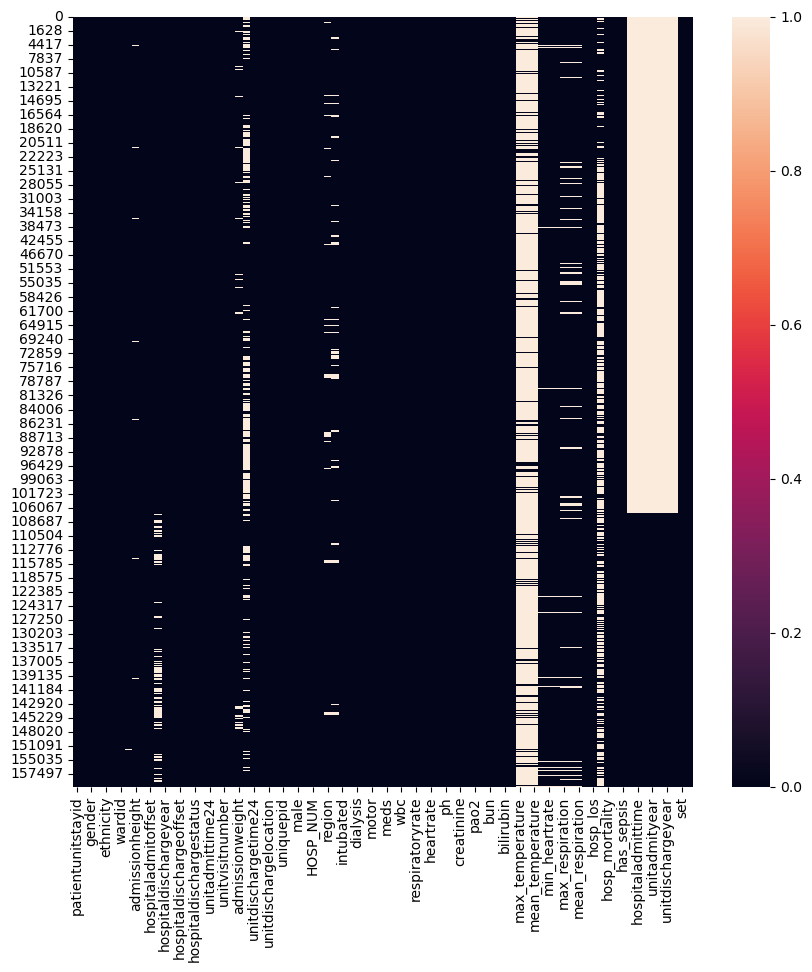

In [67]:
plt.figure(figsize=(10,10))
sns.heatmap(df.isna().astype(np.int64))

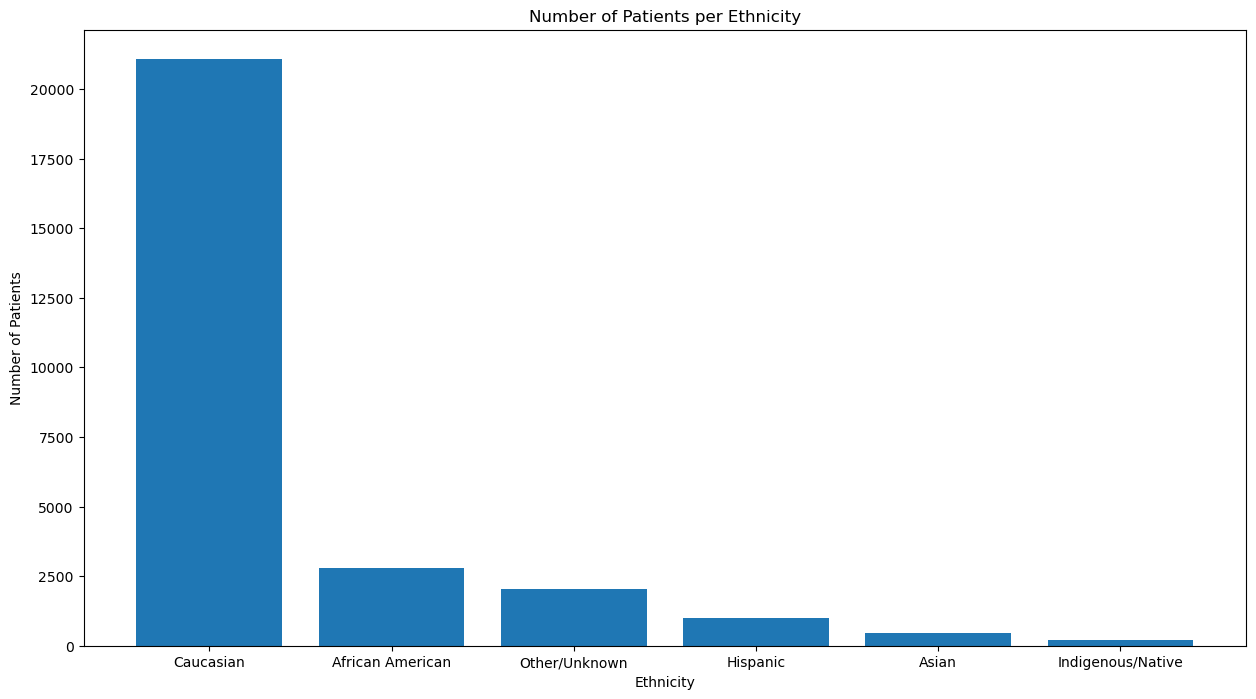

In [68]:
ethincity_counts = df['ethnicity'].value_counts()

plt.figure(figsize=(15, 8)) 
plt.bar(ethincity_counts.index, ethincity_counts.values,)
plt.title('Number of Patients per Ethnicity')
plt.xlabel('Ethnicity')
plt.ylabel('Number of Patients')
plt.show()

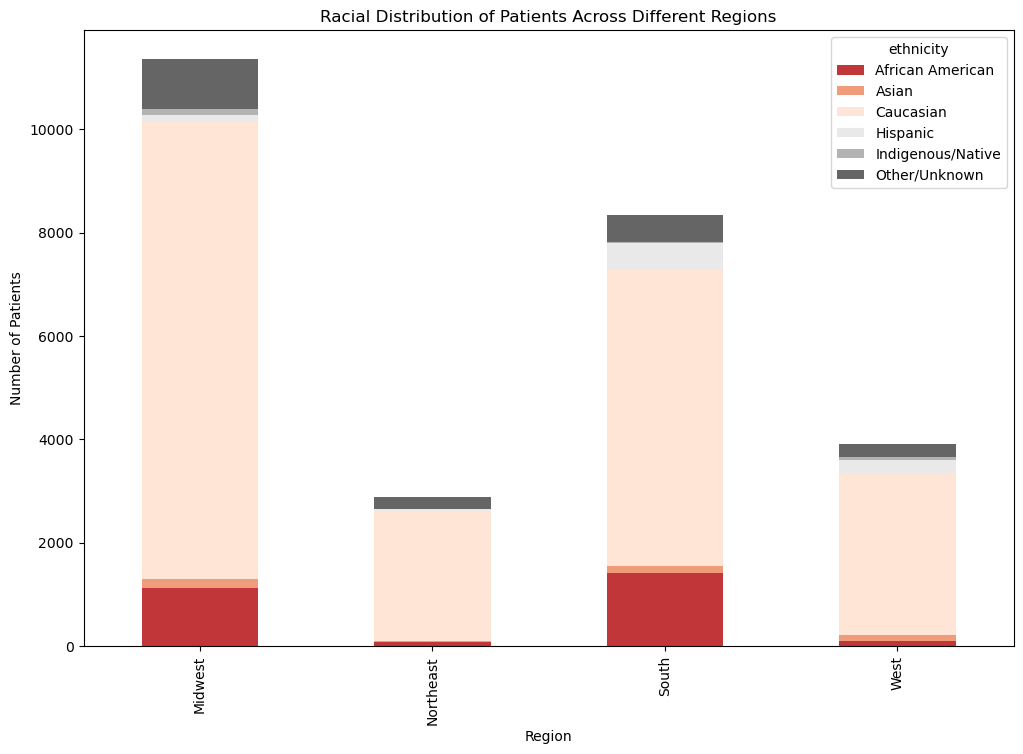

In [71]:
plt.figure(figsize=(12, 8))
df.groupby(['region', 'ethnicity']).size().unstack(fill_value=0).plot(
    kind='bar', stacked=True, color=sns.color_palette('RdGy'), ax=plt.gca())

plt.xlabel('Region')
plt.ylabel('Number of Patients')
plt.title('Racial Distribution of Patients Across Different Regions')
plt.show()

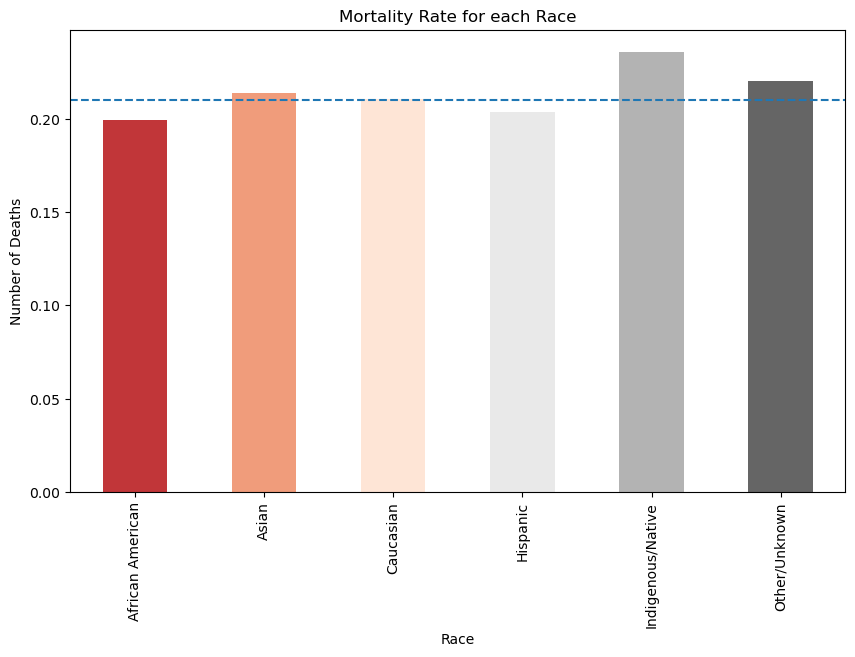

In [72]:
plt.figure(figsize=(10, 6))
df.groupby('ethnicity')['hosp_mortality'].mean().plot(kind='bar', color=sns.color_palette('RdGy'))

plt.xlabel('Race')
plt.ylabel('Number of Deaths')
plt.title('Mortality Rate for each Race')
plt.axhline(y=df['hosp_mortality'].mean(),linestyle='--')

# Show the plot
plt.show()

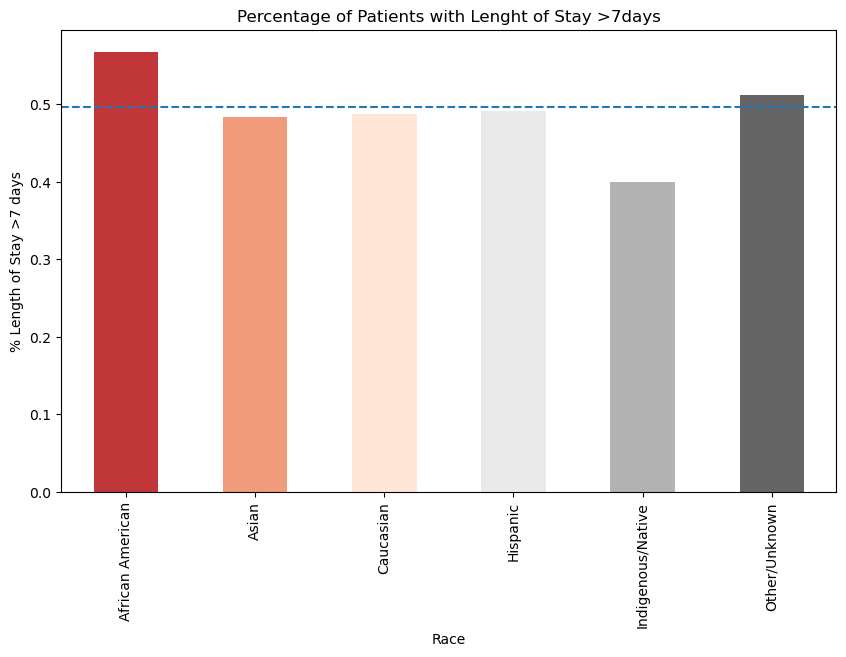

In [74]:
plt.figure(figsize=(10, 6))
df.groupby('ethnicity')['los_7d'].mean().plot(kind='bar', color=sns.color_palette('RdGy'))

plt.xlabel('Race')
plt.ylabel('% Length of Stay >7 days')
plt.title('Percentage of Patients with Lenght of Stay >7days')
plt.axhline(y=df['los_7d'].mean(),linestyle='--')

# Show the plot
plt.show()

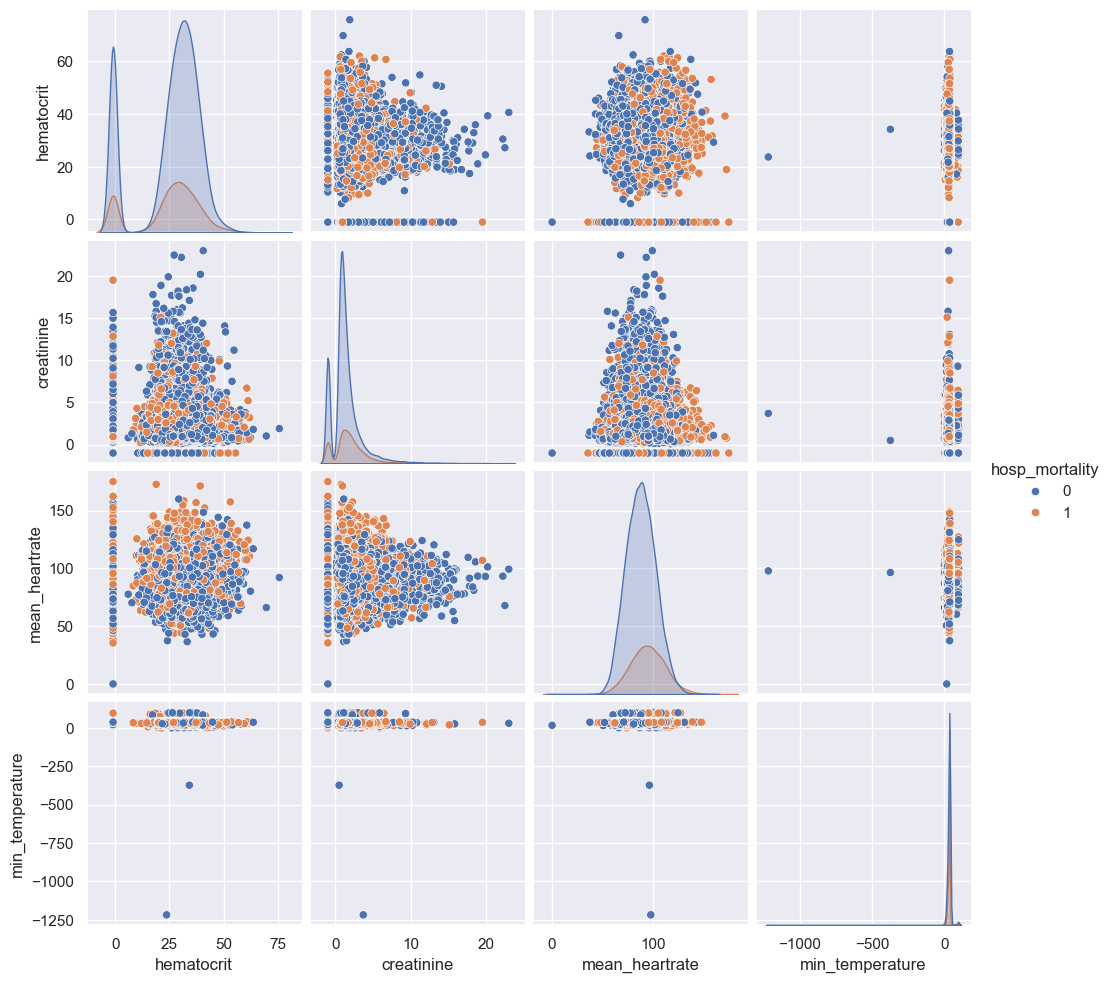

In [75]:
sns.set(font_scale=1)
sns.pairplot(df.loc[:,['hematocrit','creatinine','mean_heartrate','min_temperature','hosp_mortality']],
             hue='hosp_mortality')

In [102]:
df = df.drop(columns=[ 'patientunitstayid', 'patienthealthsystemstayid', 'gender', 'age',
       'hospitalid', 'wardid', 'apacheadmissiondx',
       'admissionheight', 'hospitaladmittime24', 'hospitaladmitoffset',
       'hospitaladmitsource', 'hospitaldischargeyear',
       'hospitaldischargetime24', 'hospitaldischargeoffset',
       'hospitaldischargelocation', 'hospitaldischargestatus', 'unittype',
       'unitadmittime24', 'unitadmitsource', 'unitvisitnumber', 'unitstaytype',
       'admissionweight', 'dischargeweight', 'unitdischargetime24',
       'unitdischargeoffset', 'unitdischargelocation', 'unitdischargestatus',
       'uniquepid','HOSP_NUM', 'teachingstatus', 'n_bed', 'eyes', 'motor',
       'verbal', 'meds', 'icu_los', 'hosp_los',
       'daysonvent', 'icu_mortality', 'hospitaladmityear',
       'hospitaladmittime', 'hospitaldischargetime', 'unitadmityear',
       'unitadmittime', 'unitdischargeyear', 'unitdischargetime',
        'max_temperature', 'min_temperature', 'mean_temperature',
        'max_heartrate','min_heartrate','mean_heartrate','max_respiration','min_respiration', 'mean_respiration', 'has_sepsis'])

In [103]:
tableone(df,
         groupby='set',
         columns=['hosp_mortality','los_7d','ethnicity', 'region'],
         order={'hosp_mortality':[1,0],'los_7d':[1,0]},
         limit={'hosp_mortality': 1,'los_7d': 1},
        )

Grouped by set                                                                  
                                               Missing       Overall        train       val_15       val_20       val_21
n                                                              26296         8533         8412         5809         3542
hosp_mortality, n (%) 1                              0   5515 (21.0)  1716 (20.1)  1800 (21.4)  1129 (19.4)   870 (24.6)
los_7d, n (%)         1                              0  13120 (49.9)  4211 (49.3)  4043 (48.1)  2879 (49.6)  1987 (56.1)
ethnicity, n (%)      African American               0   2728 (10.4)    848 (9.9)    821 (9.8)   672 (11.6)   387 (10.9)
                      Asian                                430 (1.6)    155 (1.8)    109 (1.3)    104 (1.8)     62 (1.8)
                      Caucasian                         20241 (77.0)  6660 (78.0)  6656 (79.1)  4264 (73.4)  2661 (75.1)
                      Hispanic                             930 (3.5)    377 (4.4)    319 (3.8)     66 (1.1)    168 (4.7)
                      Indigenous/Native                    185 (0.7)     57 (0.7)     47 (0.6)     59 (1.0)     22 (0.6)
                      Other/Unknown                       1782 (6.8)    436 (5.1)    460 (5.5)   644 (11.1)    242 (6.8)
region, n (%)         Midwest                        0  11238 (42.7)  3389 (39.7)  3084 (36.7)  2928 (50.4)  1837 (51.9)
                      Northeast                          2811 (10.7)   871 (10.2)    783 (9.3)   852 (14.7)    305 (8.6)
                      South                              8332 (31.7)  2495 (29.2)  2831 (33.7)  1697 (29.2)  1309 (37.0)
                      West                               3915 (14.9)  1778 (20.8)  1714 (20.4)    332 (5.7)     91 (2.6)

In [104]:
def compute_metrics_long_format(y_true,
                                y_pred_proba,
                                seed,
                                target,
                                val_set,
                                sens_attributes,
                                c_test_sens
                               ):
    results = []
    
    for sens_attribute in sens_attributes:
        c_test = c_test_sens[sens_attribute]
    
        unique_classes = c_test.unique()
    
        metrics_list = [
            'AUROC',
            # 'AUPRC',
            'Accuracy',
            'Recall',
            # 'Precision',
            'F1-score',
            # 'Balanced Accuracy'
        ]
        
        functions_list = [
            roc_auc_score,
            # average_precision_score,
            accuracy_score,
            recall_score,
            # precision_score,
            f1_score,
            # balanced_accuracy_score
        ]
    
        for cls in unique_classes:
            idx = c_test == cls
            for metric, func in zip(metrics_list, functions_list):
                try:
                    value = func(y_true[idx], (y_pred_proba[idx] > 0.5).astype(int)) \
                                               if metric not in ['AUROC','AUPRC'] else func(y_true[idx], y_pred_proba[idx])
                except:
                    value = np.nan
                
                results.append({
                    'Task': target,
                    'Validation Set': val_set,
                    'Seed': seed,
                    'Attribute': sens_attribute,
                    'Class': cls,
                    'Metric': metric,
                    'Value': value
                })
    
        # Compute metrics for all classes combined    
        overall_metrics = {}
        for metric, func in zip(metrics_list, functions_list):
            overall_metrics[metric] = func(y_true, (y_pred_proba > 0.5).astype(float))\
                                           if metric not in ['AUROC','AUPRC'] else func(y_true, y_pred_proba)
    
        for metric, value in overall_metrics.items():
            results.append({
                'Task': target,
                'Validation Set': val_set,
                'Seed': seed,
                'Attribute': '',
                'Class': 'Overall',
                'Metric': metric,
                'Value': value
            })
    
        # compute fairness metrics as well
        fairness_metrics = {}
        
        fairness_metrics_list = [
            'Demographic Parity Ratio',
            'Equalized Odds Ratio'
        ]
        
        fairness_functions_list = [
            demographic_parity_ratio,
            equalized_odds_ratio
        ]
    
        for metric, func in zip(fairness_metrics_list, fairness_functions_list):
            fairness_metrics[metric] = func(y_true=y_true,
                                            y_pred=(y_pred_proba > 0.5).astype(int),
                                            sensitive_features=c_test)
    
        for metric, value in fairness_metrics.items():
            results.append({
                'Task': target,
                'Validation Set': val_set,
                'Seed': seed,
                'Attribute': sens_attribute,
                'Class': 'Overall',
                'Metric': metric,
                'Value': value
            })

    return pd.DataFrame(results)

In [105]:
def get_sample_weights(y_train):
    
    classes_weights = compute_class_weight(
        class_weight="balanced",
        classes=np.unique(y_train),
        y=y_train
    )
    
    sample_weights = np.ones(y_train.shape[0], dtype = 'float')
    for i, val in enumerate(y_train):
        sample_weights[i] = classes_weights[int(val)]

    return sample_weights

In [106]:
def train_model(df,
                features,
                target='hosp_mortality',
                model=XGBClassifier(),
               ):
    
    X_train = df.loc[df['set'] == 'train', features]
    y_train = df.loc[df['set'] == 'train', target]

    # Train, test, eval model with sample weights
    model.fit(X_train, y_train, sample_weight=get_sample_weights(y_train))
    
    return model


def test_model(df,
               features,
               metrics_all,
               model,
               target='hosp_mortality',
               val_set=['val_15', 'val_20', 'val_21'],
               sens_attributes=['ethnicity', 'region'],
               seed=42,
              ):


    X_test = df.loc[df['set'] == val_set, features]
    y_test = df.loc[df['set'] == val_set, target]
    
    np.random.seed(s)
    resample = np.random.randint(0, len(X_test), size=int(.8*len(X_test)))

    X_test = X_test.iloc[resample]
    y_test = y_test.iloc[resample]

    # classes of sensitive attributes in the test set
    c_test_sens = df.loc[df['set'] == val_set, sens_attributes].iloc[resample]

    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    metrics_fold = compute_metrics_long_format(y_test, y_pred_proba, seed,
                                               target, val_set, sens_attributes, 
                                               c_test_sens)

    metrics_all = pd.concat([metrics_all, metrics_fold], axis=0)

    return metrics_all.drop_duplicates()
    

In [107]:
def mean_ci_agg(df):
    mean = np.mean(df)
    se = np.std(df) / np.sqrt(len(df))
    ci_width = 1.96 * se
    lower_ci = mean - ci_width
    upper_ci = mean + ci_width
    return f"{mean:.3f} ({lower_ci:.3f} - {upper_ci:.3f})"

In [108]:
def compute_p_value(group):
    group_labels = group['Validation Set'].unique()
    group_values = [group[group['Validation Set'] == label]['Value'] for label in group_labels]
    
    _, p_value = ttest_ind(*group_values)  

    if p_value < .001:
        return '<.001'
    elif p_value < .01:
        return '<.01'
    else:
        return np.round(p_value, 3)

In [109]:
def calculate_md(group):
    group_labels = group['Validation Set'].unique()
    group_values = [group[group['Validation Set'] == label]['Value'] for label in group_labels]

    mean_diff = np.mean(group_values[1]) - np.mean(group_values[0])

    return mean_diff

In [110]:
def process_metrics(metrics_all):
    
    pivoted_metrics = metrics_all.pivot(
        index=['Seed', 'Metric', 'Attribute','Class'],
        columns=['Task','Validation Set'],
        values=['Value']
    ).groupby(['Metric', 'Attribute','Class',]) \
     .agg(mean_ci_agg) \
     .droplevel(0,axis=1)

    # return pivoted_metrics
    
    # p_values = metrics_all.groupby(['Task', 'Metric', 'Attribute', 'Class']) \
    #                       .apply(compute_p_value) \
    #                       .reset_index(name='p_value') \
    #                       .pivot(
    #                           columns='Task',
    #                           index=['Metric', 'Attribute', 'Class'],
    #                           values='p_value') \
    #                       .round(3)
    
    # p_values.columns = pd.MultiIndex.from_product([p_values.columns, ['p_value']])
    # p_values.columns.name = ('Task', 'Validation Set')
    
    # pivoted_metrics_p = pd.concat([pivoted_metrics, p_values], axis=1)
    # pivoted_metrics_p.columns.name = ('Task', 'Validation Set')

    md_values = metrics_all.groupby(['Task', 'Metric', 'Attribute', 'Class']) \
        .apply(calculate_md) \
        .reset_index(name='mean_diff') \
        .pivot(
            columns='Task',
            index=['Metric', 'Attribute', 'Class'],
            values='mean_diff') \
        .round(3)

    md_values.columns = pd.MultiIndex.from_product([md_values.columns, ['mean_diff']])
    md_values.columns.name = ('Task', 'Validation Set')

    pivoted_metrics_p = pd.concat([pivoted_metrics, p_values, md_values], axis=1)
    pivoted_metrics_p.columns.name = ('Task', 'Validation Set')
   
    pivoted_metrics_p = pivoted_metrics_p.sort_index(level=[0,1], axis=1, ascending=False)
    
    return pivoted_metrics_p

In [111]:
def get_explain_plot(fit_model, X): 
    explainer = shap.Explainer(fit_model)
    shap_values = explainer.shap_values(X)  
    shap.summary_plot(shap_values, X, plot_size=(8,6)) 

In [112]:
with pd.option_context('display.max_rows', None):
    display(df.isna().sum())

ethnicity          0
age_num            0
male               0
female             0
region             0
intubated          0
vent               0
dialysis           0
urine              0
wbc                0
temperature        0
respiratoryrate    0
sodium             0
heartrate          0
meanbp             0
ph                 0
hematocrit         0
creatinine         0
albumin            0
pao2               0
pco2               0
bun                0
glucose            0
bilirubin          0
fio2               0
hosp_mortality     0
set                0
los_7d             0
dtype: int64

In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26296 entries, 0 to 159415
Data columns (total 28 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ethnicity        26296 non-null  object 
 1   age_num          26296 non-null  float64
 2   male             26296 non-null  float64
 3   female           26296 non-null  float64
 4   region           26296 non-null  object 
 5   intubated        26296 non-null  float64
 6   vent             26296 non-null  float64
 7   dialysis         26296 non-null  float64
 8   urine            26296 non-null  float64
 9   wbc              26296 non-null  float64
 10  temperature      26296 non-null  float64
 11  respiratoryrate  26296 non-null  float64
 12  sodium           26296 non-null  float64
 13  heartrate        26296 non-null  float64
 14  meanbp           26296 non-null  float64
 15  ph               26296 non-null  float64
 16  hematocrit       26296 non-null  float64
 17  creatinine      

In [119]:
int_columns = df.select_dtypes(include=['int', 'Float64']).columns
df[int_columns] = df[int_columns].astype(float)

In [121]:
def process_metrics_n(metrics_all):
    print("Initial metrics_all:")
    print(metrics_all.head())

    try:
        pivoted_metrics = metrics_all.pivot(
            index=['Seed', 'Metric', 'Attribute', 'Class'],
            columns=['Task', 'Validation Set'],
            values='Value'
        )
        print("Pivoted metrics:")
        print(pivoted_metrics.head())
    except Exception as e:
        print("Error during pivot:", e)
        raise

    try:
        pivoted_metrics = pivoted_metrics.groupby(['Metric', 'Attribute', 'Class']).agg(mean_ci_agg)
        print("Grouped and aggregated metrics:")
        print(pivoted_metrics.head())
    except Exception as e:
        print("Error during grouping and aggregation:", e)
        raise
    return pivoted_metrics

In [122]:
seeds = np.arange(0, 10, 1)
val_sets = ['val_15', 'val_20', 'val_21']
targets = [
    'hosp_mortality',
    'los_7d',
    # 'odd_icustay_id' # outcome control
]
sens_attributes = [
    'ethnicity',
    'region'
    # 'sex_female' # sensitive attribute control
]

models = [
    LGBMClassifier(verbosity=-1),
    RandomForestClassifier(),
    XGBClassifier(),
]
models_names = [
                'LGBM',
                'RF',
                'XGB'
                ]


for model, model_name in zip(models, models_names):
    print(model_name)

    metrics_all = pd.DataFrame()
    
    for t in targets:
        print(t)
        features = df.columns.drop(['hosp_mortality','los_7d','set'] + sens_attributes)
        fit_model = train_model(
            df,
            features,
            t,
                model,  
        )
        for vs in val_sets:
                for s in tqdm(seeds):
                    
                    metrics_all = test_model(
                        df,
                        features,
                        metrics_all=metrics_all,
                        model=fit_model,
                        target=t,
                        val_set=vs,
                        sens_attributes=sens_attributes,
                        seed=s,
                    )
        pivoted_metrics = process_metrics_n(metrics_all)
        pivoted_metrics.to_csv(f'covid_{model_name}.csv')

LGBM
hosp_mortality


100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  3.73it/s]


Initial metrics_all:
             Task Validation Set  Seed  Attribute      Class    Metric  \
0  hosp_mortality         val_15     0  ethnicity  Caucasian     AUROC   
1  hosp_mortality         val_15     0  ethnicity  Caucasian  Accuracy   
2  hosp_mortality         val_15     0  ethnicity  Caucasian    Recall   
3  hosp_mortality         val_15     0  ethnicity  Caucasian  F1-score   
4  hosp_mortality         val_15     0  ethnicity   Hispanic     AUROC   

      Value  
0  0.804020  
1  0.782049  
2  0.637205  
3  0.564504  
4  0.766660  
Pivoted metrics:
Task                                   hosp_mortality                    
Validation Set                                 val_15    val_20    val_21
Seed Metric Attribute Class                                              
0    AUROC            Overall                0.805109  0.793040  0.776327
            ethnicity African American       0.838868  0.832551  0.823679
                      Asian                  0.718553  0.858676

100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  3.88it/s]


Initial metrics_all:
             Task Validation Set  Seed  Attribute      Class    Metric  \
0  hosp_mortality         val_15     0  ethnicity  Caucasian     AUROC   
1  hosp_mortality         val_15     0  ethnicity  Caucasian  Accuracy   
2  hosp_mortality         val_15     0  ethnicity  Caucasian    Recall   
3  hosp_mortality         val_15     0  ethnicity  Caucasian  F1-score   
4  hosp_mortality         val_15     0  ethnicity   Hispanic     AUROC   

      Value  
0  0.804020  
1  0.782049  
2  0.637205  
3  0.564504  
4  0.766660  
Pivoted metrics:
Task                                   hosp_mortality                      \
Validation Set                                 val_15    val_20    val_21   
Seed Metric Attribute Class                                                 
0    AUROC            Overall                0.805109  0.793040  0.776327   
            ethnicity African American       0.838868  0.832551  0.823679   
                      Asian                  0.7

100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  3.84it/s]


Initial metrics_all:
             Task Validation Set  Seed  Attribute      Class    Metric  \
0  hosp_mortality         val_15     0  ethnicity  Caucasian     AUROC   
1  hosp_mortality         val_15     0  ethnicity  Caucasian  Accuracy   
2  hosp_mortality         val_15     0  ethnicity  Caucasian    Recall   
3  hosp_mortality         val_15     0  ethnicity  Caucasian  F1-score   
4  hosp_mortality         val_15     0  ethnicity   Hispanic     AUROC   

      Value  
0  0.806005  
1  0.814331  
2  0.239899  
3  0.364217  
4  0.779363  
Pivoted metrics:
Task                                   hosp_mortality                    
Validation Set                                 val_15    val_20    val_21
Seed Metric Attribute Class                                              
0    AUROC            Overall                0.808444  0.787943  0.774753
            ethnicity African American       0.853378  0.823522  0.793813
                      Asian                  0.761006  0.906977

100%|███████████████████████████████████████████| 10/10 [00:03<00:00,  3.11it/s]


Initial metrics_all:
             Task Validation Set  Seed  Attribute      Class    Metric  \
0  hosp_mortality         val_15     0  ethnicity  Caucasian     AUROC   
1  hosp_mortality         val_15     0  ethnicity  Caucasian  Accuracy   
2  hosp_mortality         val_15     0  ethnicity  Caucasian    Recall   
3  hosp_mortality         val_15     0  ethnicity  Caucasian  F1-score   
4  hosp_mortality         val_15     0  ethnicity   Hispanic     AUROC   

      Value  
0  0.806005  
1  0.814331  
2  0.239899  
3  0.364217  
4  0.779363  
Pivoted metrics:
Task                                   hosp_mortality                      \
Validation Set                                 val_15    val_20    val_21   
Seed Metric Attribute Class                                                 
0    AUROC            Overall                0.808444  0.787943  0.774753   
            ethnicity African American       0.853378  0.823522  0.793813   
                      Asian                  0.7

100%|███████████████████████████████████████████| 10/10 [00:03<00:00,  3.30it/s]


Initial metrics_all:
             Task Validation Set  Seed  Attribute      Class    Metric  \
0  hosp_mortality         val_15     0  ethnicity  Caucasian     AUROC   
1  hosp_mortality         val_15     0  ethnicity  Caucasian  Accuracy   
2  hosp_mortality         val_15     0  ethnicity  Caucasian    Recall   
3  hosp_mortality         val_15     0  ethnicity  Caucasian  F1-score   
4  hosp_mortality         val_15     0  ethnicity   Hispanic     AUROC   

      Value  
0  0.780480  
1  0.785221  
2  0.521886  
3  0.518611  
4  0.728030  
Pivoted metrics:
Task                                   hosp_mortality                    
Validation Set                                 val_15    val_20    val_21
Seed Metric Attribute Class                                              
0    AUROC            Overall                0.784262  0.768811  0.747874
            ethnicity African American       0.835636  0.824410  0.801739
                      Asian                  0.639937  0.842576

100%|███████████████████████████████████████████| 10/10 [00:03<00:00,  3.27it/s]

Initial metrics_all:
             Task Validation Set  Seed  Attribute      Class    Metric  \
0  hosp_mortality         val_15     0  ethnicity  Caucasian     AUROC   
1  hosp_mortality         val_15     0  ethnicity  Caucasian  Accuracy   
2  hosp_mortality         val_15     0  ethnicity  Caucasian    Recall   
3  hosp_mortality         val_15     0  ethnicity  Caucasian  F1-score   
4  hosp_mortality         val_15     0  ethnicity   Hispanic     AUROC   

      Value  
0  0.780480  
1  0.785221  
2  0.521886  
3  0.518611  
4  0.728030  
Pivoted metrics:
Task                                   hosp_mortality                      \
Validation Set                                 val_15    val_20    val_21   
Seed Metric Attribute Class                                                 
0    AUROC            Overall                0.784262  0.768811  0.747874   
            ethnicity African American       0.835636  0.824410  0.801739   
                      Asian                  0.6

In [132]:
pivoted_metrics

Task                                                         hosp_mortality  \
Validation Set                                                       val_15   
Metric                   Attribute Class                                      
AUROC                              Overall            0.787 (0.784 - 0.790)   
                         ethnicity African American   0.821 (0.812 - 0.829)   
                                   Asian              0.698 (0.670 - 0.726)   
                                   Caucasian          0.782 (0.778 - 0.785)   
                                   Hispanic           0.778 (0.759 - 0.798)   
                                   Indigenous/Native  0.886 (0.841 - 0.931)   
                                   Other/Unknown      0.809 (0.795 - 0.822)   
                         region    Midwest            0.774 (0.769 - 0.780)   
                                   Northeast          0.779 (0.764 - 0.793)   
                                   South              0.795 (0.787 - 0.803)   
                                   West               0.797 (0.792 - 0.802)   
Accuracy                           Overall            0.796 (0.793 - 0.798)   
                         ethnicity African American   0.821 (0.814 - 0.827)   
                                   Asian              0.790 (0.761 - 0.819)   
                                   Caucasian          0.791 (0.789 - 0.794)   
                                   Hispanic           0.803 (0.793 - 0.813)   
                                   Indigenous/Native  0.871 (0.839 - 0.904)   
                                   Other/Unknown      0.800 (0.792 - 0.808)   
                         region    Midwest            0.805 (0.801 - 0.810)   
                                   Northeast          0.796 (0.784 - 0.809)   
                                   South              0.795 (0.791 - 0.798)   
                                   West               0.780 (0.777 - 0.783)   
Demographic Parity Ratio ethnicity Overall            0.563 (0.448 - 0.677)   
                         region    Overall            0.761 (0.727 - 0.796)   
Equalized Odds Ratio     ethnicity Overall            0.266 (0.159 - 0.373)   
                         region    Overall            0.663 (0.606 - 0.721)   
F1-score                           Overall            0.528 (0.522 - 0.534)   
                         ethnicity African American   0.564 (0.541 - 0.586)   
                                   Asian              0.346 (0.289 - 0.403)   
                                   Caucasian          0.524 (0.518 - 0.529)   
                                   Hispanic           0.514 (0.489 - 0.539)   
                                   Indigenous/Native  0.743 (0.683 - 0.803)   
                                   Other/Unknown      0.535 (0.513 - 0.557)   
                         region    Midwest            0.462 (0.451 - 0.473)   
                                   Northeast          0.562 (0.536 - 0.587)   
                                   South              0.542 (0.530 - 0.554)   
                                   West               0.573 (0.561 - 0.586)   
Recall                             Overall            0.528 (0.521 - 0.535)   
                         ethnicity African American   0.554 (0.533 - 0.575)   
                                   Asian              0.335 (0.274 - 0.396)   
                                   Caucasian          0.523 (0.515 - 0.532)   
                                   Hispanic           0.539 (0.496 - 0.582)   
                                   Indigenous/Native  0.672 (0.576 - 0.768)   
                                   Other/Unknown      0.575 (0.548 - 0.601)   
                         region    Midwest            0.496 (0.481 - 0.511)   
                                   Northeast          0.497 (0.468 - 0.526)   
                                   South              0.543 (0.532 - 0.553)   
                                   West           

In [125]:
print(metrics_all.columns)
print(metrics_all.dtypes)

Index(['Task', 'Validation Set', 'Seed', 'Attribute', 'Class', 'Metric',
       'Value'],
      dtype='object')
Task               object
Validation Set     object
Seed                int64
Attribute          object
Class              object
Metric             object
Value             float64
dtype: object


In [156]:
metrics_all

,Task,Validation Set,Seed,Attribute,Class,Metric,Value
0,hosp_mortality,val_15,0,ethnicity,Caucasian,AUROC,0.780480
1,hosp_mortality,val_15,0,ethnicity,Caucasian,Accuracy,0.785221
2,hosp_mortality,val_15,0,ethnicity,Caucasian,Recall,0.521886
3,hosp_mortality,val_15,0,ethnicity,Caucasian,F1-score,0.518611
4,hosp_mortality,val_15,0,ethnicity,Hispanic,AUROC,0.728030
...,...,...,...,...,...,...,...
43,los_7d,val_21,9,region,West,Accuracy,0.730769
44,los_7d,val_21,9,region,West,Recall,0.735294
45,los_7d,val_21,9,region,West,F1-score,0.704225
50,los_7d,val_21,9,region,Overall,Demographic Parity Ratio,0.815401


In [162]:
attribute = 'ethnicity'  # or 'region'
metric = 'AUROC' 
filtered_df = metrics_all[(metrics_all['Attribute'] == attribute) & (metrics_all['Metric'] == metric)]
filtered_df

,Task,Validation Set,Seed,Attribute,Class,Metric,Value
0,hosp_mortality,val_15,0,ethnicity,Caucasian,AUROC,0.780480
4,hosp_mortality,val_15,0,ethnicity,Hispanic,AUROC,0.728030
8,hosp_mortality,val_15,0,ethnicity,Other/Unknown,AUROC,0.805077
12,hosp_mortality,val_15,0,ethnicity,African American,AUROC,0.835636
16,hosp_mortality,val_15,0,ethnicity,Asian,AUROC,0.639937
...,...,...,...,...,...,...,...
4,los_7d,val_21,9,ethnicity,African American,AUROC,0.609164
8,los_7d,val_21,9,ethnicity,Other/Unknown,AUROC,0.631322
12,los_7d,val_21,9,ethnicity,Hispanic,AUROC,0.629827
16,los_7d,val_21,9,ethnicity,Asian,AUROC,0.699074


In [165]:
df_grouped = filtered_df.groupby(['Validation Set', 'Class'])['Value'].mean().reset_index()
df_grouped

,Validation Set,Class,Value
0,val_15,African American,0.725589
1,val_15,Asian,0.623524
2,val_15,Caucasian,0.702751
3,val_15,Hispanic,0.741689
4,val_15,Indigenous/Native,0.775877
5,val_15,Other/Unknown,0.735474
6,val_20,African American,0.705328
7,val_20,Asian,0.725448
8,val_20,Caucasian,0.695632
9,val_20,Hispanic,0.702240


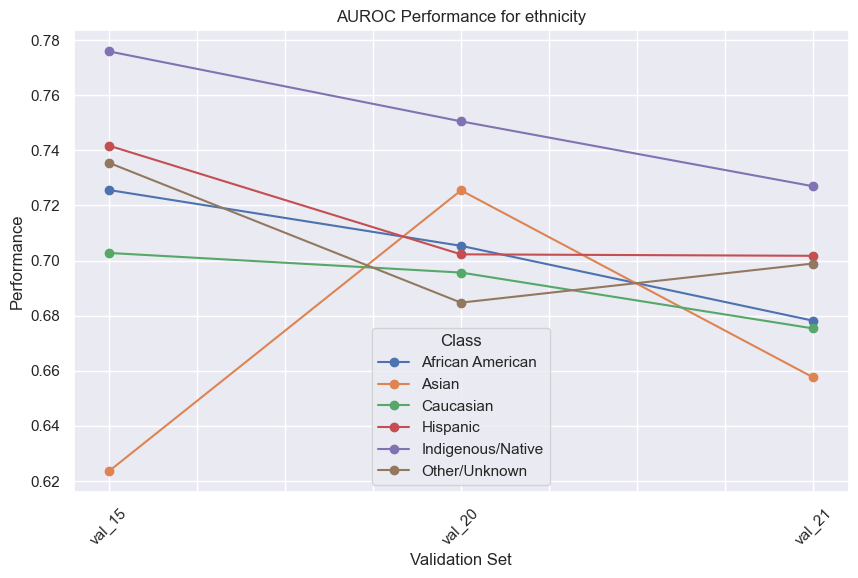

In [163]:
attribute = 'ethnicity'  # or 'region'
metric = 'AUROC'           # or 'Accuracy'

# Filter the data for the specified Attribute and Metric
filtered_df = metrics_all[(metrics_all['Attribute'] == attribute) & (metrics_all['Metric'] == metric)]

# 2. Group by 'Validation Set', 'Class', and aggregate 'Value'
df_grouped = filtered_df.groupby(['Validation Set', 'Class'])['Value'].mean().reset_index()

# 3. Pivot the DataFrame so that 'Validation Set' is the index, 'Class' is the columns, and 'Value' is the values
df_pivot = df_grouped.pivot_table(index='Validation Set', columns='Class', values='Value')

# 4. Plotting the data
df_pivot.plot(kind='line', marker='o', figsize=(10, 6), title=f"{metric} Performance for {attribute}")
plt.ylabel('Performance')
plt.xlabel('Validation Set')
plt.xticks(rotation=45)
plt.legend(title='Class')
plt.grid(True)
plt.show()